##  SolverFinal: <br>
- version: 1 <br>
solves the korteweg-de Vries in form of $-u_t=\alpha u_{3x}  + 2\sigma uu_x + cu_x$ and implements the nudging method in the following steps:
    - solves just the kawahara to get artificial data u
    - only keeps data points separated by a spacing of h=integer*dx and interpolates using scipy griddata to get vector $I_h(u)$
    - solves the nudged equation for the Kawahra $-v_t=\alpha v_{3x}  + 2\sigma vv_x + cv_x -\eta (I_h(v)-I_h(u))$
    - Measures convergence by plotting maximum absolute different between u and v against time.
    - solution animation available
<br>
- version summary :
    - Documented
    - IC is soliton solution for the kDV from [this link](https://www.maplesoft.com/applications/view.aspx?SID=4187&view=html)
    - Method: Centered finite difference of $2^{nd}$ order accuracy in space and $1^{st}$ in time
    - Padding for periodic B.Cs
    - Optional damping/forcing terms
<br>


In [2]:
import pandas as pd
import numpy as np
import scipy as sc
import scipy.stats as ss


import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
from math import *

import scipy.optimize as so
from scipy.optimize import fsolve
from scipy import sparse

from scipy.sparse import diags 
from mpmath import findroot, atanh

In [2]:

L=2*np.pi # period




tFinal=2

nx=200
dx=L/(nx-1)
x = np.linspace(-L/2,L/2,nx) # define space
dt = 0.001 # defining mesh grid width for space
nt = int(np.round(tFinal/dt) +1) # number of time steps
t = np.linspace(0,tFinal,nt) # define time



### parameters ###

alpha=1

sigma=3
c=0
Gamma=0
Forcing=0
IntMthd='linear'
parameters=[['alpha',alpha],['beta',beta],['sigma',sigma]]


NameError: name 'beta' is not defined

In [ ]:
###### here is the stability computation all in one area ######
###############################################################

# declaring some constants
thirdAlpha = 1.
fifthBeta =1/4
nonlinSigma = 1.
c = thirdAlpha - fifthBeta
L = (np.pi)*2
spacex = np.linspace(0,L,501);
conSteps =1500 # number of continuation steps
a1=1.0e-6 # beginning amplitude
aF=1.0e-2 # ending amplitude
aS = np.linspace(a1,aF,conSteps) # vector of free parameter a1 (amplitudes)
velocities=np.zeros(conSteps) # Tracks all the velocities for bifurcation branch
NN=21 # number of modes at which the Fourier series is truncated 
uguess = np.zeros(NN+2)


uguess[0]=c # uguess is our initial guess vector, it has zeros everywhere, except for first two elements: c and a1
uguess[1] =a1
V=c
for k in range(conSteps):


    solution=fsolve(kawaharainitial, uguess, args=(aS[k], thirdAlpha, fifthBeta, nonlinSigma, NN),xtol=1.e-8) #notice amplitude changes with every iteration
    soln=solution[1::] #all the As (excludes speed)

    V = solution[0]
    uguess=np.concatenate((V,solution[1],aS[k],solution[3::]),axis=None) #update initial guess
    

# generating the solution in real space made of cosines
    phi = soln[0]*np.cos(0.*spacex);
    phix = -0.*soln[0]*np.sin(0.*spacex)
    ii = 0.
    for aii in soln[1:]:
        ii = ii+1.
        phi = phi + aii*np.cos(ii*spacex)
        phix = phix - (ii)*aii*np.sin(ii*spacex)





    velocities[k]=solution[0]



# rescaling to get zero average
    phi = phi - soln[0]
    V = V - 2.*soln[0]

plt.plot(spacex,phi)

In [ ]:
print('nx is:',nx,'dx is:',dx)
print('nt is:',nt, 'dt is',dt)
print('ratio dt/dx is',dt/dx)
print(nx)
Nh

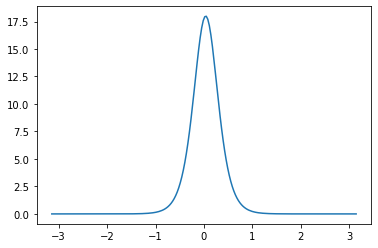

In [3]:

ufull=np.zeros([nx,nt])  #define the solution matrix

k=3
u=2*k**2/(np.cosh(k*(x-k**2*4*0.001)))**2
ufull[:,0]=u
plt.plot(x,u)

## Function kdv <br>
This function models the KDV equation with optional damping and forcing terms $0=u_t + \alpha u_{3x} + 2\sigma uu_x + \gamma u_{xx} + forcing$. The equation is broken up using finite difference methods of 2nd order accuracy in space and 1st order accuracy in time. The discretized equation is    $0=\frac{1}{dt}(U_i-un_i)+\frac{\alpha}{dx^3}(-\frac{1}{2}uav_{i-2}+1uav_{i-1}-1uav_{i+1}+\frac{1}{2}uav_{i+2})+2\frac{\sigma}{dx}(-\frac{1}{2}uav_{i-1}+\frac{1}{2}uav_{i+1})(uav_{i})-\frac{\gamma}{dx^2}(1uav_{i-1}-2uav_{i}+1uav_{i+1})+forcing_{i-2}$ <br>
where <br>
$U$ is the unknown future solution <br>
$un$ is the known current solution <br>
$i$ is the space index <br>
uav is an average between the future unknown time and the current known time by implementing Crank-Nicolson scheme: $uav=\frac{U+un}{2}$ <br>




## Input parameters:
- U: solution vector in space x at time t
- gamma: coefficient for the damping term $\gamma u_{xx}$. Default value set to Gamma
- forcing: coefficient for forcing, can take on values of 0 (no forcing term), 1 ($A\cos(\kappa x- \omega t)$) or 2 ($A\omega t \cos(\kappa x)$). Default value set to Forcing
- omega, kappa, A: forcing term parameters

## Output parameters:
- Kawahara equation in form of $0=\alpha u_{3x} \beta u_{5x} + 2\sigma uu_x + cu_x - u_t$ <br>
<br>
examaple use: <br>
kawahara(np.ones(x.size),nx)

In [4]:
### finite difference coefficients,2nd order accuracy ### 


def kdv(U,gamma=Gamma,forcing=Forcing,omega=1,kappa=1,A=1):
   
    soln=np.zeros(nx,dtype='float64') 
    # here we pad some of our vectors so that it can implement periodic boundary conditions
    Upad=np.hstack((U[nx-3],U[nx-2],U,U[1],U[2]))
    unpad=np.hstack((un[nx-3],un[nx-2],un,un[1],un[2]))
    uavpad=1/2*(Upad+unpad)
    
    try:

        if forcing==0:
            forcing=np.zeros(nx,dtype='float64')
        elif forcing==1:
            forcing=A*np.cos(kappa*x-omega*time)
        elif forcing==2:
            forcing=A*omega*time*np.cos(kappa*x)
    except TypeError as e:
        print('Wrong')
        
        


    for i in range(2,nx+2):

        
        soln[i-2]=1/dt*(Upad[i]-unpad[i])+alpha/(dx**3)*(-1/2*uavpad[i-2]+1*uavpad[i-1]-1*uavpad[i+1]+1/2*uavpad[i+2])+2*sigma/(dx)*(-1/2*uavpad[i-1]+1/2*uavpad[i+1])*(uavpad[i])-gamma/dx**2*(1*uavpad[i-1]-2*uavpad[i]+1*uavpad[i+1])+forcing[i-2]

        
  
    return soln
                                                                                                                 
                                                                                                           

In [5]:
# loop through times and use fsolve to solve the unknown vector U for every timestep
for n in range(1,nt): #for every time step
    time=(t[n]+t[n-1])/2
    un = u.copy().real #copy existing values of u into un
    
    u=fsolve(kdv, un,xtol=1.e-8)

    ufull[:,n]=u #nth time column
 


import os
os.system('say "your program has finished"')    

KeyboardInterrupt: 

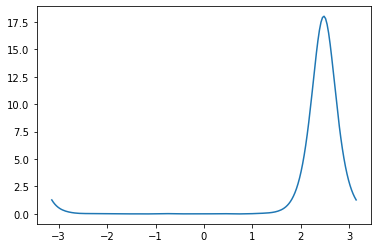

In [63]:
# plotting the final time
tFinal =nt-1
# plt.plot(x, np.cos(x-alpha*(tFinal)*dt),'r')
plt.plot(x, ufull[:,tFinal])

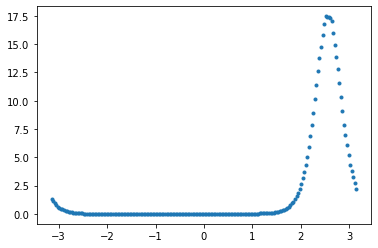

In [106]:
### Interpolation of data ###
from scipy.interpolate import griddata
h=4*dx
Nh=int((L/h) +1)
xh=np.linspace(-L/2,L/2,Nh)
uh=np.zeros([Nh,nt])
for T in range(nt):
    if int(h/dx) %2 ==2: # even spacing
        uh[:,T]=ufull[0:nx:int(h/dx),T]
    else:  # odd spacing 
        uh[:,T]=ufull[0:nx-1:int(h/dx),T]
        
    
unew=np.zeros([nx,nt]) # new interpolated data matrix with same size as original data
for T in range(nt):
    unew[:,T]= griddata(xh, uh[:,T], x, method=IntMthd)
plt.plot(x,unew[:,nt-1],'.')

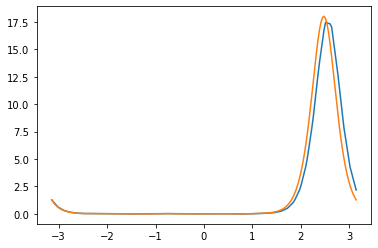

In [107]:
 plt.plot(x,unew[:,nt-1],x,ufull[:,nt-1])

## Function kdvNudge <br>
This function adds a nudging term to the kdv equation in the form of  $0=v_t + \alpha v_{3x} + 2\sigma vv_x + \gamma v_{xx} +nudg(I_{hv}-I_{hu}) + forcing$. The discretized equation is    $0=\frac{1}{dt}(U_i-un_i)+\frac{\alpha}{dx^3}(-\frac{1}{2}uav_{i-2}+1uav_{i-1}-1uav_{i+1}+\frac{1}{2}uav_{i+2})+2\frac{\sigma}{dx}(-\frac{1}{2}uav_{i-1}+\frac{1}{2}uav_{i+1})(uav_{i})-\frac{\gamma}{dx^2}(1uav_{i-1}-2uav_{i}+1uav_{i+1})+forcing_{i-2} +nudg(I_{hv}-I_{hu})$ <br>
where <br>
$U$ is the unknown future solution <br>
$un$ is the known current solution <br>
$i$ is the space index <br>
uav is an average between the future unknown time and the current known time by implementing Crank-Nicolson scheme: $uav=\frac{U+un}{2}$ <br>
Note: Crank Nicolson has also been applied to the interpolated solution vector

In [190]:
nudg=30000 #nudging coefficient


def kdvNudge(U,gamma=Gamma,forcing=Forcing,kappa=1,omega=1):
   
    soln=np.zeros(nx,dtype='float64') 
    Upad=np.hstack((U[nx-3],U[nx-2],U,U[1],U[2]))
    unpad=np.hstack((un[nx-3],un[nx-2],un,un[1],un[2]))
    uavpad=1/2*(Upad+unpad)
    Ih=U[0:nx:int(h/dx)] #create sparse vector for unknown solution vector
    Ih2=un[0:nx:int(h/dx)] #create sparse vector for the known solution vector
    Ihnew= griddata(xh, Ih, x, method='linear') # Interpolated unknown solution vector
    Ihnew2= griddata(xh, Ih2, x, method='linear') # Interpolated known solution vector
    Ihv=1/2*(Ihnew+Ihnew2) # Cranknicolson 
    Ihvpad=np.hstack((Ihv[nx-3],Ihv[nx-2],Ihv,Ihv[1],Ihv[2]))
    
    try:

        if forcing==0:
            forcing=np.zeros(nx,dtype='float64')
        elif forcing==1:
            forcing=np.cos(kappa*x-omega*time)
        elif forcing==2:
            forcing=omega*time*np.cos(kappa*x)
    except TypeError as e:
        print('Wrong')
        
        

    

    

    for i in range(2,nx+2):

        
        soln[i-2]=1/dt*(Upad[i]-unpad[i])+alpha/(dx**3)*(-1/2*uavpad[i-2]+1*uavpad[i-1]-1*uavpad[i+1]+1/2*uavpad[i+2])+2*sigma/(dx)*(-1/2*uavpad[i-1]+1/2*uavpad[i+1])*(uavpad[i])-gamma/dx**2*(1*uavpad[i-1]-2*uavpad[i]+1*uavpad[i+1])+nudg*(Ihvpad[i]-Ihu[i-2])+forcing[i-2]

        
  
    return soln
                                                                                                                 
        
                                                                                                                 
                                                                                                           

In [191]:
vfull=np.zeros([nx,nt])


u=np.cos(x)+1e-4*np.cos(3*x)

vfull[:,0]=u

In [193]:

# loop through times and use fsolve to solve the unknown vector U for every timestep
for n in range(1,nt): #for every time step
    time=(t[n]+t[n-1])/2
    un = u.copy().real #copy existing values of u into un

    Ihu=1/2*(unew[:,n]+unew[:,n-1])
    
    
    u=fsolve(kdvNudge, un,xtol=1.e-8)

    vfull[:,n]=u #nth time column
 


import os
os.system('say "your program has finished"')    

nudging coefficient is 10000


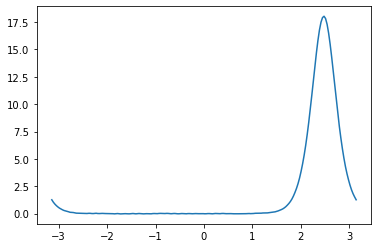

In [176]:
plt.plot(x,vfull[:,nt-1])
print('nudging coefficient is',nudg)

nx is: 200 dx is: 0.03157379551346526
nt is: 2001 dt is 0.001
ratio dt/dx is 0.03167183367528717
nudging coefficient is 50000


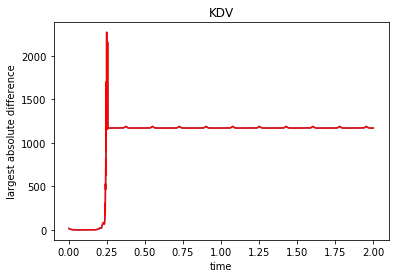

In [189]:
  # This cell plots the biggest absolute difference in our solution for every time t and time t+1   
from numpy import linalg as LA

growth=np.zeros((1,nt))
growth2=np.zeros((1,nt))
for time in range(nt):
    growth[0,time]=np.max(abs(ufull[:,time]-vfull[:,time]))
    growth2[0,time]=LA.norm(ufull[:,time]-vfull[:,time], np.inf)

plt.plot(t,growth.transpose())    
plt.plot(t,growth2.transpose(),'r')  
# plt.ylim(0,13)


plt.title('KDV')
plt.xlabel('time')
plt.ylabel('largest absolute difference')
print('nx is:',nx,'dx is:',dx)
print('nt is:',nt, 'dt is',dt)
print('ratio dt/dx is',dt/dx)
print('nudging coefficient is',nudg)

## Animation

In [47]:
from matplotlib import animation, rc
from IPython.display import HTML

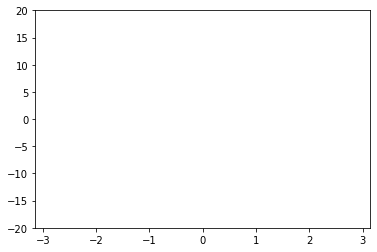

In [48]:
fig, ax = plt.subplots()

ax.set_xlim(( -L/2, L/2))
ax.set_ylim((-20, 20))

line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    return (line,line2,)

In [49]:
def animate(i):
    y=ufull[:,i*5]
    y2=vfull[:,i*5]
    line.set_data(x,y,)
    
    line2.set_data(x,y2)
    
    return(line,line2,)

In [50]:
# call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int((nt-1)/5), interval=100) #frames is nt

In [51]:


print('nudging coefficient is',nudg)
HTML(anim.to_jshtml())

nudging coefficient is 100
